<a href="https://colab.research.google.com/github/FreddyR424/Deep_Learning/blob/master/COVID_Chest_X_Ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 Chest X-Ray Classification**

## **Context**
- The Coronavirus Pandemic (also called COVID-19) needs no introduction, having become one of the deadliest pandemics in recorded history since the identification of its first known case in December 2019. Patients diagnosed with this condition suffer from variable symptoms, such as fever, cough, headache, loss of smell, and loss of taste. Although most patients only develop mild-to-moderate symptoms, a significant percentage of the population suffers from severe-to-critical level symptoms. The disease has not only claimed millions of lives all over the globe, but has fundamentally changed the ways in which each of us relates to and navigates the world, having impacted the human health, financial standing and work-life behavior of nearly every nation's economy in some way or the other.
- In response to the acute medical challenges associated with the outbreak, Deep Learning algorithms have started being employed for medical image classification to help with COVID-19 diagnosis. Convolutional Neural Networks (CNN) are one such solution used to identify COVID-19 directly from Chest X-Rays, to assist radiologists in medical analysis of the lungs by classifying patients depending on whether they're healthy, have viral pneumonia, or are affected by COVID-19.

## **Objective**
- Build a Convolutional Neural Network to differentiate an X-ray image of a person affected with COVID-19 from that of a healthy person or a person who has viral pneumonia (fever).

## **Data Description**
- This dataset contains training set images of 3 classes which are converted into Numpy arrays.
- The dataset comprises of 3 classes:
1. COVID-19: Patients who are COVID-positive.
2. Viral Pneumonia: This is a viral fever that has similar characteristics and symptoms to COVID but is not as severe.
3. Normal: A healthy Person with no symptoms of COVID or fever.
- The data file names are:
1. CovidImages.npy
2. CovidLabels.csv

## **Imports**

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization               # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam, SGD                                                # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## **Reading the Dataset**

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/CovidImages.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/CovidLabels.csv')

## **Overview of Dataset**

In [4]:
print(images.shape)
print(labels.shape)

(251, 128, 128, 3)
(251, 1)


- data is stored in a 4-dimensional Numpy array.
- The first dimension 251 denotes the number of images in the training data, and each image is stacked on top of the other as a 3-dimensional Numpy array.
- The second dimension 128 denotes the number of pixels along the X-axis, the third dimension 128 denotes the number of pixels along the Y-axis, and the fourth dimension 3 is the total number of channels in those images.

## **Exploratory Data Analysis**
- Converting Numpy arrays to images and visualizing some random images.

In [5]:
def plot_images(images, labels):

  num_classes = 10                                                                # Number of Classes
  categories = np.unique(labels)   

  keys = dict(labels['Label'])                                                    # Obtaing the unique classes from y_train

  rows = 3                                                                        # Defining number of rows = 3
  cols = 4                                                                        # Defining number of columns = 4
  fig = plt.figure(figsize = (10, 8))                                             # Defining the figure size to 10 x 8

  for i in range(cols):
      for j in range(rows):

          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
          
  plt.show()

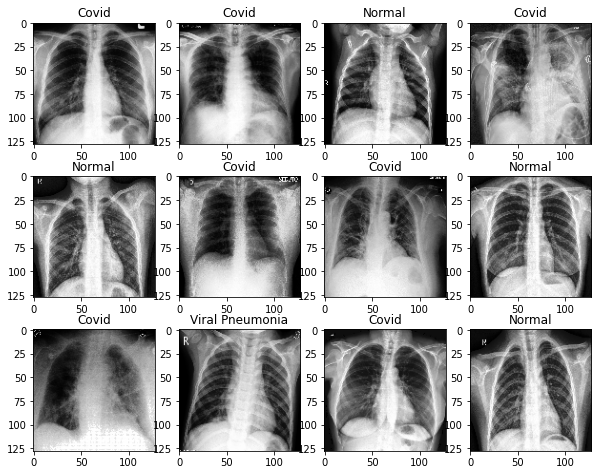

In [6]:
plot_images(images, labels)

### **Checking for Data Imbalance**

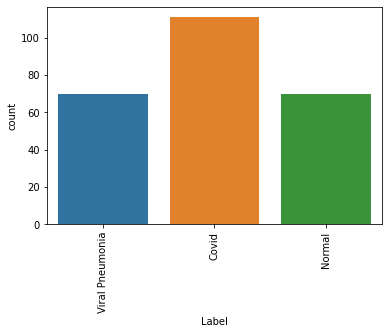

In [7]:
sns.countplot(labels['Label']);
plt.xticks(rotation = 'vertical'); 

-  the data is not highly imbalanced, but the number of images for the COVID category are somewhat more in comparison to the other two categories. So we can use the appropriate evaluation methods for imbalanced classification like Precision and Recall to evaluate this model.

## **Resizing Images**
- reduce the image size from 128 to 64.

In [8]:
images_decreased = []

height = 64
width = 64

dimensions = (width, height)  

for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation = cv2.INTER_LINEAR))

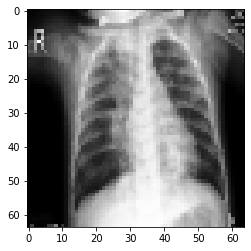

In [9]:
plt.imshow(images_decreased[3])

## **Splitting the Dataset**
- we will use 10% of our data for testing and 90% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset while keeping the test size constant at 0.1. This means that 10% of total data is used for testing, while 90% is used for training.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(images_decreased), labels, test_size = 0.1, random_state = 42, stratify = labels)

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(225, 64, 64, 3) (225, 1)
(26, 64, 64, 3) (26, 1)


## **Making Data Compatible**
- Converting the labels from names to one hot vectors
- Normalizing the values

## **Encoding the target labels**

In [12]:
# Convert labels from names to one hot vectors.
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_test_encoded = enc.transform(y_test)

In [13]:
enc.classes_


array(['Covid', 'Normal', 'Viral Pneumonia'], dtype='<U15')

In [14]:
y_train_encoded.shape, y_test_encoded.shape

((225, 3), (26, 3))

## **Data Normalization**
- Normalization makes the training faster and reduces the chances of getting stuck at local optima.
- Also, weight decay and estimation can be done more conveniently with normalized inputs.
- In deep neural networks, normalization helps to avoid exploding gradient problems. The exploding gradient problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn from the training data.

**As we know, image pixel values range from 0 - 255, so we are simply dividing all the pixel values by 255 to standardize all the images to have values between 0 - 1.**

In [15]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## **Model Building - Convolutional Neural Network (CNN)**
Create a CNN model sequentially, where we will be adding the layers one after another.

- First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.
- Then, we will fix the seed value.

In [16]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**Building a CNN Model with the following 2 main parts:**
- 1. The Feature Extraction layers which are comprised of convolutional and pooling layers.
- 2. The Fully Connected classification layers for prediction.

In [17]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
model1.add(Conv2D(128, (3, 3), activation = 'relu', padding = "same", input_shape = (64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(64, (3, 3), activation = 'relu', padding = "same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model1.add(Dense(8, activation = 'relu'))
model1.add(Dropout(0.3))

# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem  
model1.add(Dense(3, activation = 'softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate = 0.01, momentum = 0.9)
opt=Adam()

# Compile model
model1.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 8)                 1

## **Fitting Model on Train Data**

In [19]:
history_1 = model1.fit(
    X_train_normalized, y_train_encoded,
    epochs = 10,
    validation_split = 0.1,
    shuffle = False,
    batch_size = 64,
    verbose = 1
)

Epoch 1/10
4/4 [==============================] - 6s 1s/step - loss: 1.1614 - accuracy: 0.4010 - val_loss: 1.1172 - val_accuracy: 0.1739
Epoch 2/10
4/4 [==============================] - 4s 945ms/step - loss: 1.0819 - accuracy: 0.4950 - val_loss: 1.0398 - val_accuracy: 0.5652
Epoch 3/10
4/4 [==============================] - 4s 939ms/step - loss: 1.0206 - accuracy: 0.5149 - val_loss: 0.9525 - val_accuracy: 0.5652
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 0.8890 - accuracy: 0.5594 - val_loss: 0.8985 - val_accuracy: 0.5652
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 0.8531 - accuracy: 0.5347 - val_loss: 0.7934 - val_accuracy: 0.6087
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 0.7525 - accuracy: 0.5941 - val_loss: 0.7782 - val_accuracy: 0.6087
Epoch 7/10
4/4 [==============================] - 6s 1s/step - loss: 0.7652 - accuracy: 0.6188 - val_loss: 0.7641 - val_accuracy: 0.5652
Epoch 8/10
4/4 [===================

## **Model Evaluation**

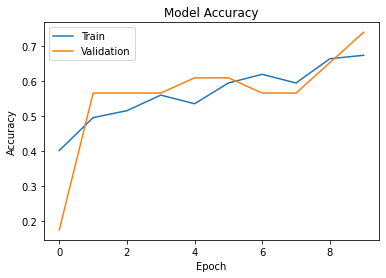

In [20]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

- We can see from the above plot that the training accuracy of the model was not good and the validation accuracy was also not good.
- This shows that the model is not stable and not performing well.

## **Evaluating the model on test data**

In [21]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

1/1 - 1s - loss: 0.5814 - accuracy: 0.7692 - 543ms/epoch - 543ms/step


## **Plotting Confusion Matrix**
- We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.

In [22]:
y_pred = model1.predict(X_test_normalized)

1/1 [==============================] - 0s 377ms/step


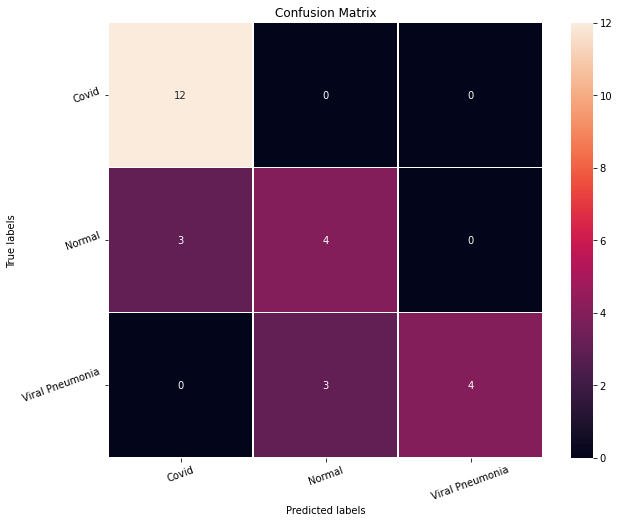

In [23]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded, axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

- In comparison to the rest, we can see that classes Normal and Viral Pneumonia are often misclassified. There are a few cases that are normal but are predicted to have COVID and a few cases that are Viral Pneumonia but are predicted to be normal.
- The COVID category seems to be predicted well but we need to build a model which would also classify the Normal and Viral Pneumonia classes correctly.
- We can observe that the model does not confuse Viral Pneumonia and COVID, which is a good thing. Also, most of the images with the COVID class are predicted correctly, and this is the most desired output since a patient having COVID should never be misclassified with other classes as being healthy or only having a viral fever.

### **Deleting the model and history variable to use the RAM efficiently**

In [24]:
del model1
del history_1

## **Using Data Augmentation to check if it can improve over the Base Model**
- Reducing the Learning Rate

In [25]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                            patience = 3, 
                                            verbose = 1, 
                                            factor = 0.5, 
                                            min_lr = 0.0001)

## **Data Augmentation**

In [26]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [27]:
# Creating the data generator
datagen_train = ImageDataGenerator(
                              rotation_range = 20, 
                              fill_mode = 'nearest',
                              )

In [28]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
model2.add(Conv2D(16, (3, 3), activation = 'relu', padding = "same", input_shape = (64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(Conv2D(8, (3, 3), activation = 'relu', padding = "same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

model2.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model2.add(Dense(16, activation = 'relu'))
model2.add(Dropout(0.3))

# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem  
model2.add(Dense(3, activation = 'softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate = 0.01, momentum = 0.9)
opt=Adam(learning_rate = 0.001)

# Compile model
model2.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Generating the summary of the model
model2.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 8)        32        
 ormalization)                                                   
                                                        

In [30]:
# Epochs
epochs = 10

# Batch size
batch_size = 64

history = model2.fit(datagen_train.flow(X_train_normalized, y_train_encoded,
                                       batch_size = batch_size, 
                                       shuffle = False),
                                       epochs = epochs,
                                       steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                                       validation_data = (X_test_normalized, y_test_encoded),
                                       verbose = 1, callbacks = [learning_rate_reduction])

Epoch 1/10
3/3 [==============================] - 3s 585ms/step - loss: 1.1545 - accuracy: 0.4472 - val_loss: 1.0547 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 2/10
3/3 [==============================] - 1s 291ms/step - loss: 0.5935 - accuracy: 0.8075 - val_loss: 0.9821 - val_accuracy: 0.6538 - lr: 0.0010
Epoch 3/10
3/3 [==============================] - 1s 237ms/step - loss: 0.5039 - accuracy: 0.8323 - val_loss: 0.9214 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 4/10
3/3 [==============================] - 1s 245ms/step - loss: 0.4520 - accuracy: 0.8385 - val_loss: 0.8895 - val_accuracy: 0.5769 - lr: 0.0010
Epoch 5/10
3/3 [==============================] - 1s 209ms/step - loss: 0.4169 - accuracy: 0.8385 - val_loss: 0.9177 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 0.4224 - accuracy: 0.8509
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 [==============================] - 1s 228ms/step - loss: 0.4224

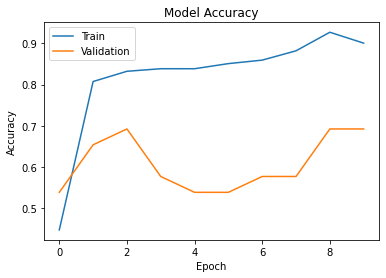

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [32]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

1/1 - 0s - loss: 0.7968 - accuracy: 0.6923 - 39ms/epoch - 39ms/step


In [33]:
y_pred = model2.predict(X_test_normalized)

1/1 [==============================] - 0s 101ms/step


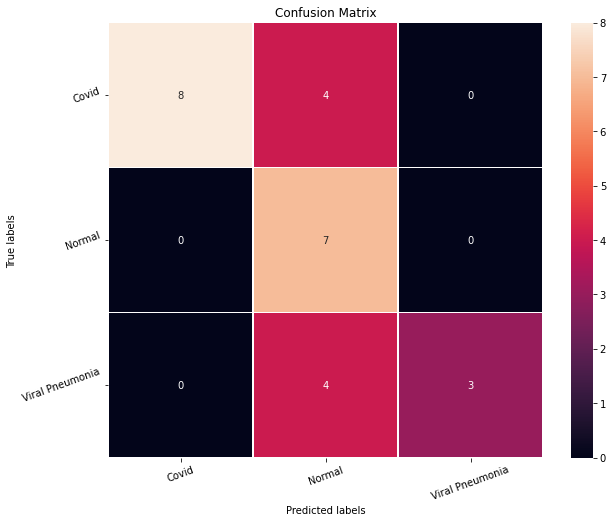

In [34]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded,axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

- We can observe that the model has predicted most cases having covid to be normal. This can be fatal, if a patient having severe case of Covid is to be classified as being normal.
- We cannot accept this model and we have to look at alternative architectures.

## **Visualizing the Prediction**

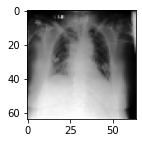

1/1 [==============================] - 0s 82ms/step
Predicted Label ['Covid']
True Label Covid


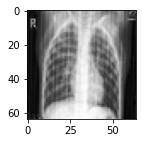

1/1 [==============================] - 0s 52ms/step
Predicted Label ['Normal']
True Label Viral Pneumonia


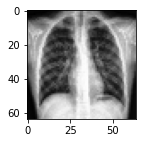

1/1 [==============================] - 0s 35ms/step
Predicted Label ['Normal']
True Label Normal


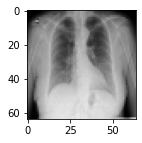

1/1 [==============================] - 0s 29ms/step
Predicted Label ['Normal']
True Label Covid


In [35]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize = (2, 2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[2].reshape(1, 64, 64, 3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                                   # using inverse_transform() to get the output label from the output vector

plt.figure(figsize = (2, 2))
plt.imshow(X_test[10])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[10].reshape(1, 64, 64, 3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[10])                                                  # using inverse_transform() to get the output label from the output vector

plt.figure(figsize = (2, 2))
plt.imshow(X_test[20], )
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[20].reshape(1, 64, 64, 3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[20])                                                  # using inverse_transform() to get the output label from the output vector

plt.figure(figsize = (2, 2))
plt.imshow(X_test[5])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[5].reshape(1, 64, 64, 3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[5])          

- We observe that all the above images were classified correctly.
- This shows that data augmentation has helped in creating a generalized model.

In [36]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()
# Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [37]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (64, 64, 3))
vgg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [38]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Add classification layers on top of it  
x = Flatten()(transfer_layer.output) # Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.3)(x)

x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

pred = Dense(3, activation = 'softmax')(x)

model3 = Model(vgg.input, pred) # Initializing the model

In [39]:
# Compiling the model 
model3.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
              metrics = ['accuracy'])

In [41]:
# Epochs
epochs = 10

# Batch size
batch_size = 64

history = model3.fit(datagen_train.flow(X_train_normalized, y_train_encoded,
                                       batch_size = batch_size, 
                                       shuffle = False),
                                       epochs = epochs,
                                       steps_per_epoch = X_train_normalized.shape[0] // batch_size,
                                       validation_data = (X_test_normalized, y_test_encoded),
                                       verbose = 1)

Epoch 1/10
3/3 [==============================] - 11s 3s/step - loss: 0.7438 - accuracy: 0.4596 - val_loss: 0.6072 - val_accuracy: 0.5385
Epoch 2/10
3/3 [==============================] - 10s 4s/step - loss: 0.5278 - accuracy: 0.7640 - val_loss: 0.5476 - val_accuracy: 0.7308
Epoch 3/10
3/3 [==============================] - 11s 4s/step - loss: 0.4829 - accuracy: 0.7453 - val_loss: 0.5061 - val_accuracy: 0.7308
Epoch 4/10
3/3 [==============================] - 12s 4s/step - loss: 0.4101 - accuracy: 0.8281 - val_loss: 0.4704 - val_accuracy: 0.8846
Epoch 5/10
3/3 [==============================] - 11s 4s/step - loss: 0.3887 - accuracy: 0.8261 - val_loss: 0.4408 - val_accuracy: 0.8846
Epoch 6/10
3/3 [==============================] - 10s 4s/step - loss: 0.3572 - accuracy: 0.8634 - val_loss: 0.4273 - val_accuracy: 0.9231
Epoch 7/10
3/3 [==============================] - 16s 5s/step - loss: 0.3078 - accuracy: 0.8958 - val_loss: 0.4232 - val_accuracy: 0.9231
Epoch 8/10
3/3 [==================

In [42]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose = 2)

1/1 - 1s - loss: 0.4171 - accuracy: 0.9231 - 1s/epoch - 1s/step


In [43]:
y_pred = model3.predict(X_test_normalized)

1/1 [==============================] - 1s 1s/step


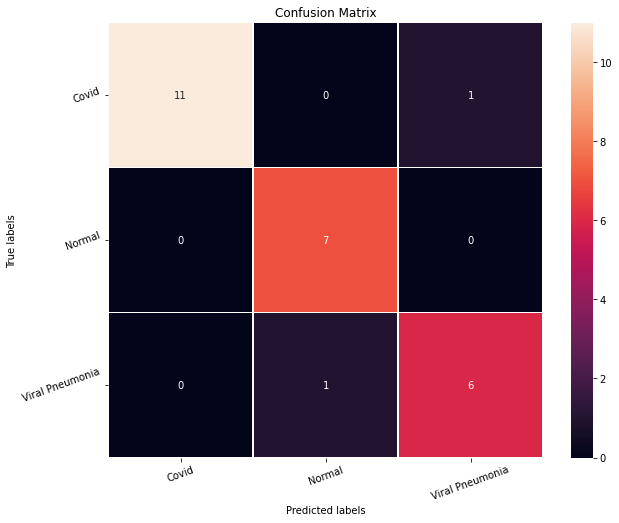

In [44]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg = np.argmax(y_pred, axis = 1)
y_test_arg = np.argmax(y_test_encoded,axis = 1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)

f, ax = plt.subplots(figsize = (10, 8))

sns.heatmap(
    confusion_matrix,
    annot = True,
    linewidths = .4,
    fmt = "d",
    square = True,
    ax = ax
)

# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
ax.yaxis.set_ticklabels(['Covid', 'Normal', 'Viral Pneumonia'], rotation = 20)
plt.show()

- We observe that our Transfer Learning model is the best model so far, as it has predicted the majority of the classes correctly with minimum misclassifications.
- The Transfer Learning model showed the best results in training, and also has the best accuracy during testing.
- Data Augmentation has also helped in improving the overall model performance.

## **Conclusion**
- Convolutional Neural Networks (CNNs), as we see above, are able to excel at making predictions on images.
- CNNs do this to a greater level than statistical Machine Learning techniques and Artificial Neural Networks (ANNs), because those algorithms flatten the spatial structure of an image right at the start, whereas CNNs only do so after applying a series of feature extraction steps on the image, such as Convolutions, Pooling, Padding, and non-linear Activation Functions.
- Some of the reasons CNNs are advantageous over ANNs in making predictions on image data, are Spatial and Translational Invariance, the ability to extract important features and discard unimportant ones, and their relative computational efficiency over ANNs.
- Medical research has been a domain that has benefited greatly from the ability of CNNs in image prediction tasks. The best CNNs, with architectural modifications necessary for the unique use cases of the medical domain, have been shown to rival and sometimes even surpass the performance of experienced radiologists at tasks like tumor detection, and can hence serve as a useful source of second opinion for medical professionals in diagnosis and decision-making.
- Being able to automate this task using CNNs would represent benefits such as the ability to provide faster observations than a human, and the ability to handle a larger volume of the same task. Secondly, as a piece of software, it could be distributed anywhere in the world, including in less well-connected regions of the world that may not have access to experts capable of such diagnoses from X-ray scans.
- However, Deep Learning based solutions have a few hurdles to overcome before mainstream acceptance. Their lack of explainability, their brittleness and susceptibility to small perturbations in images, and the need to achieve very high performance on evaluation metrics for acceptance, makes it difficult to currently use them as a singular source of truth, and they can only be considered as a part of the decision-making process in assistance to medical professionals qualified for these operations.